![Pneumonia](https://miro.medium.com/max/6300/1*MRB9XKm6Prd-w-7Ss6Bf8w.jpeg)

### <span style="background-color: #66f4d3">"Pneumonia killed more than 808,000 children under the age of 5 in 2017, accounting for 15% of all deaths of children under 5 years. People at-risk for pneumonia also include adults over the age of 65 and people with preexisting health problems."</span> — WHO

***Pneumonia is a common lung infection caused by bacteria, a virus or fungi. It is often spread via coughing, sneezing, touching or even breathing, and those who don't exhibit symptoms can also spread the illness.***

***Many factors affect how serious a case of pneumonia is, such as the type of germ causing the lung infection, the person’s age, and their overall health. The people most at risk are infants and young children, adults 65 or older, and people who have other health problems.***

***Pneumonia is a leading cause of hospitalization in both children and adults. Most cases can be treated successfully, although it can take weeks to fully recover. Tens of thousands of people in the U.S. die from pneumonia every year, most of them adults over the age of 65.***

# Problem Statement

**Diagnosing pneumonia in a CXR accurately is difficult. Expert radiologists are required to review the CXR and also require confirmation through clinical examinations. You are tasked to classify CXRs with pneumonia from their normal CXR counterparts, using machine learning and computer vision techniques.**

# Loading Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras 
import tensorflow as tf
import cv2
from keras.applications import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import h5py
from skimage import exposure
import os 
import glob
import cv2
from skimage import img_as_float
from scipy.ndimage.filters import gaussian_filter
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score


import warnings 
warnings.filterwarnings("ignore")

# Loading and preparing training data

In [2]:
# dataset directory
train_dir = '../input/pn-hack/pneumonia_dataset/pneumonia_dataset/train'
test_dir = '../input/pn-hack/pneumonia_dataset/pneumonia_dataset/test'

In [3]:
import pandas as pd
df = pd.read_csv('../input/pn-hack/pneumonia_dataset/pneumonia_dataset/test.csv')
df.head()

,filename
0,CXR_test_519.png
1,CXR_test_578.png
2,CXR_test_359.png
3,CXR_test_573.png
4,CXR_test_471.png


In [4]:
# image datagenerator instantiation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2,)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [5]:
# Reading Data

training_data = train_gen.flow_from_directory(directory=train_dir,
                                             target_size = (224,224),
                                             shuffle=True,
                                             batch_size= 10,
                                             subset = 'training')

validation_data = train_gen.flow_from_directory(directory=train_dir,
                                             target_size = (224,224),
                                             shuffle=True,
                                             batch_size= 10,
                                             subset = 'validation')

test_data = test_gen.flow_from_dataframe(dataframe=df,
                                         directory=test_dir,
                                         target_size = (224,224),
                                         shuffle=False,
                                         batch_size= 10,
                                         class_mode=None,
                                             )

Found 1940 images belonging to 2 classes.
Found 485 images belonging to 2 classes.
Found 606 validated image filenames.


# EDA

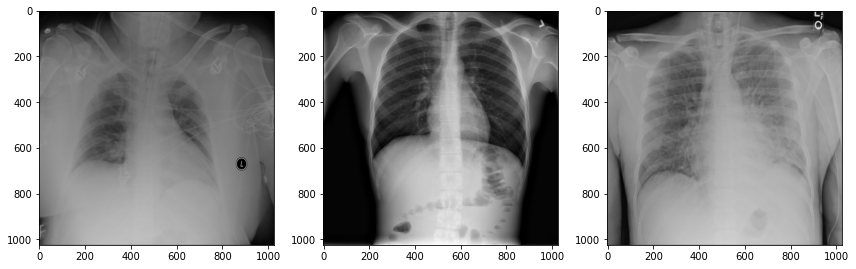

In [6]:
disease_cls = ['pneumonia','normal']

# Normal Images

normal_path = os.path.join(train_dir, disease_cls[1], '*')
normal_images = glob.glob(normal_path)

plt.figure(figsize=(12,10))

for i in enumerate(normal_images[0:3]):
    plt.subplot(1,3, i[0]+1)
    img = cv2.imread(i[1])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.tight_layout()
    plt.imshow(img)

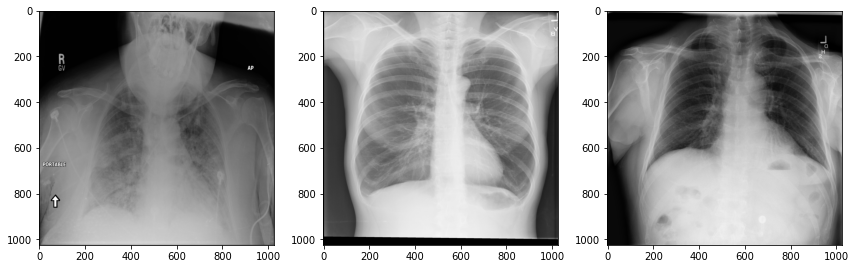

In [7]:
# pneumonia Images

pneumonia_path = os.path.join(train_dir, disease_cls[0], '*')
pneumonia_images = glob.glob(pneumonia_path)

plt.figure(figsize=(12,10))

for i in enumerate(pneumonia_images[0:3]):
    plt.subplot(1,3, i[0]+1)
    img = cv2.imread(i[1])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.tight_layout()
    plt.imshow(img)


In [8]:
# Image preprocessing functions

def unsharp_mask(image,radius=5,amount=1.5):

    image = img_as_float(image) # ensuring float values for computations

    blurred_image = gaussian_filter(image, sigma=radius)

    mask = image - blurred_image # keep the edges created by the filter
    sharpened_image = image + mask * amount

    sharpened_image = np.clip(sharpened_image, float(0), float(1)) # Interval [0.0, 1.0]
    sharpened_image = (sharpened_image*255).astype(np.uint8) # Interval [0,255]

    return sharpened_image

def clahe(image):
    x = exposure.equalize_adapthist(image ,clip_limit=0.08)
    return x

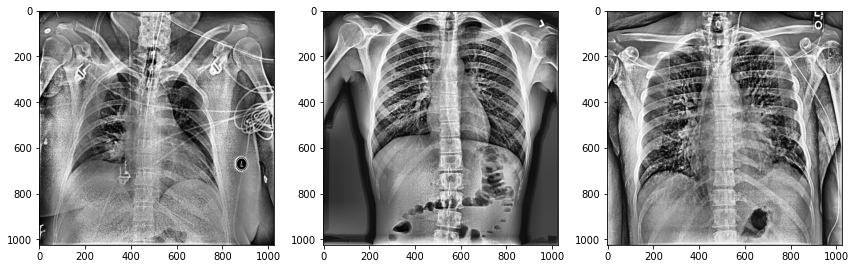

In [9]:
# applying preprocessing on Normal Images

plt.figure(figsize=(12,10))

for i in enumerate(normal_images[0:3]):
    plt.subplot(1,3, i[0]+1)
    img = cv2.imread(i[1])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = unsharp_mask(img)
    img = clahe(img)
    plt.tight_layout()
    plt.imshow(img)

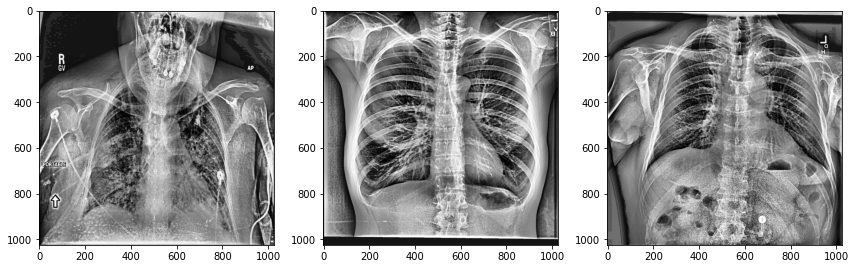

In [10]:
# applying preprocessin on pneumonia images

plt.figure(figsize=(12,10))

for i in enumerate(pneumonia_images[0:3]):
    plt.subplot(1,3, i[0]+1)
    img = cv2.imread(i[1])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = unsharp_mask(img)
    img = clahe(img)
    plt.tight_layout()
    plt.imshow(img)

# CheXNet

**Using Transfer learning methods here, CheXNet is a 121-layer convolutional neural network(Densenet-121) trained on ChestX-ray14 dataset, developed by Stanford ML Group.**

In [11]:
# path of pretrained models weights
weights_path = '../input/pn-hack/brucechou1983_CheXNet_Keras_0.3.0_weights.h5/brucechou1983_CheXNet_Keras_0.3.0_weights.h5'

In [12]:
base_model = DenseNet121(weights=None,
                        include_top=False,
                        input_shape=(224,224,3), pooling="avg")


l_2 = tf.keras.layers.Dense(64)(base_model.output)
n_1 = tf.keras.layers.BatchNormalization()(l_2)
a_1 = tf.keras.layers.Activation('relu')(n_1)
d_1 = tf.keras.layers.Dropout( 0.2)(a_1)


predictions = tf.keras.layers.Dense(2, activation='softmax', name='predictions')(d_1)

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
model.load_weights(weights_path, by_name = True, skip_mismatch = True)
model.layers.pop()

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [14]:
# checking for class imbalance

# calculate the class weights
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(training_data.classes), training_data.classes)
cw = dict(zip( np.unique(training_data.classes), weights))
print(cw)

{0: 0.947265625, 1: 1.0589519650655022}


In [15]:
#filepath to save best model
filepath = 'DPHi_' + 'Pneumonia _Classification_Segmind.h5'

In [16]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00005),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.AUC()])

In [17]:
# Callbacks 

checkpoint = ModelCheckpoint(filepath= filepath, save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='auto')

In [18]:
model.fit_generator(generator=training_data, validation_data=validation_data, 
                         epochs= 10,callbacks=[checkpoint, lr_reduce],class_weight= {0: 0.947265625, 1: 1.0589519650655022})

Epoch 1/10
194/194 [==============================] - 61s 249ms/step - loss: 0.7255 - auc: 0.6176 - val_loss: 0.6528 - val_auc: 0.6845
Epoch 2/10
194/194 [==============================] - 45s 234ms/step - loss: 0.5594 - auc: 0.8102 - val_loss: 0.5461 - val_auc: 0.8143
Epoch 3/10
194/194 [==============================] - 45s 231ms/step - loss: 0.5038 - auc: 0.8466 - val_loss: 0.5007 - val_auc: 0.8472
Epoch 4/10
194/194 [==============================] - 45s 233ms/step - loss: 0.5140 - auc: 0.8391 - val_loss: 0.5038 - val_auc: 0.8433
Epoch 5/10
194/194 [==============================] - 45s 232ms/step - loss: 0.4812 - auc: 0.8591 - val_loss: 0.5009 - val_auc: 0.8448

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.4999999621068127e-05.
Epoch 6/10
194/194 [==============================] - 45s 234ms/step - loss: 0.4315 - auc: 0.8888 - val_loss: 0.4824 - val_auc: 0.8542
Epoch 7/10
194/194 [==============================] - 45s 230ms/step - loss: 0.4288 - auc: 0.8915 - val_loss

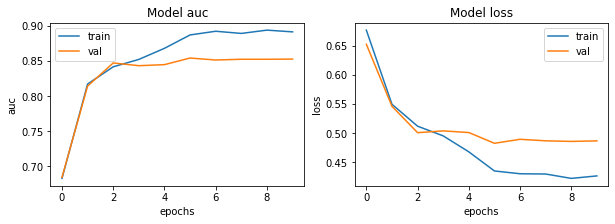

In [19]:
# plotting losses and AUC

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(model.history.history[met])
    ax[i].plot(model.history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

**After the 6th epoch val loss is not decreasing, but train loss is decreasing gradually.**

# checking on Validation

In [29]:
validation_data = train_gen.flow_from_directory(directory=train_dir,
                                             target_size = (224,224),
                                             shuffle=False,
                                             batch_size= 10,
                                             subset = 'validation')

Found 485 images belonging to 2 classes.


In [30]:
val_pred = model.predict_generator(validation_data)

# pnemonia probablities

val_pred = val_pred[:,1]             # predected 
val_true = validation_data.classes   # True

# Finding Optimal Cut-Off

In [31]:
def Find_Optimal_Cutoff(target, predicted):
  
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [32]:
threshold = Find_Optimal_Cutoff(target=val_true, predicted=val_pred)
print(threshold)

[0.5002114176750183]


In [33]:
predictions = []

for item in val_pred:
    if item <=threshold:
        predictions.append(0)
    else:
        predictions.append(1)

In [34]:
f1_score(y_true=val_true, y_pred=predictions)

0.7592190889370932

# On Test

In [35]:
# test predections
test_pred = model.predict_generator(test_data)
test_pred = test_pred[:,1]

test_predictions = []

for item in test_pred:
    if item <= threshold:
        test_predictions.append('normal')
    else:
        test_predictions.append('pneumonia')

In [36]:
df['label'] = test_predictions
df.head()

,filename,label
0,CXR_test_519.png,pneumonia
1,CXR_test_578.png,normal
2,CXR_test_359.png,normal
3,CXR_test_573.png,pneumonia
4,CXR_test_471.png,normal


In [37]:
# saving test csv
df.to_csv( "Pneumonia _Classification_Segmind_Test_Pred.csv", index=False)